# Test Models

This notebook tests deep learning models for enhanced JPEG reconstruction.

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.backend import eval as tf_eval
import skimage.measure as metrics

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from cs_models import deep_cascade_unet_no_dc

Using TensorFlow backend.


In [2]:
# Train and validation data paths
test_path = "../../Gray/*.tif"

# Listing train and validation images
images = glob.glob(test_path)
test_images = images[45000:]

# Summary of images
print("Test set size:", len(test_images))

Test set size: 3624


In [3]:
H,W = 256, 256
norm = 255.0
compr_range = (5,6)

test_unc = np.zeros((len(test_images),H,W,1), dtype=np.float32)
test_compr = test_unc.copy()

compr_test = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(test_images),replace = True)

# Test set
for ii in range(len(test_images)):
    # Load uncompressed image
    im1 = Image.open(test_images[ii])
    test_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_test[ii]))
    im2 = Image.open(buf)
    test_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)

test_unc -= 128.0
test_compr -= 128.0

test_unc /= 128.0
test_compr /= 128.0

In [4]:
opt=Adam(lr=0.001)
model_name = "../Models/residual_unet_d_data_augmentation_compress_5-imagenet.hdf5"
model=deep_cascade_unet_no_dc(depth_str='d')
model.compile(loss = "mse",optimizer=opt)

model.load_weights(model_name)

0 d
Append DCT layer
Append U-net block
Append iDCT layer


In [5]:
pred = model.predict(test_compr)

In [6]:
test_unc *= 128.0
test_unc += 128.0

test_compr *= 128.0
test_compr += 128.0

pred *= 128.0
pred += 128.0

0.0 254.0
-7.573227 259.1175


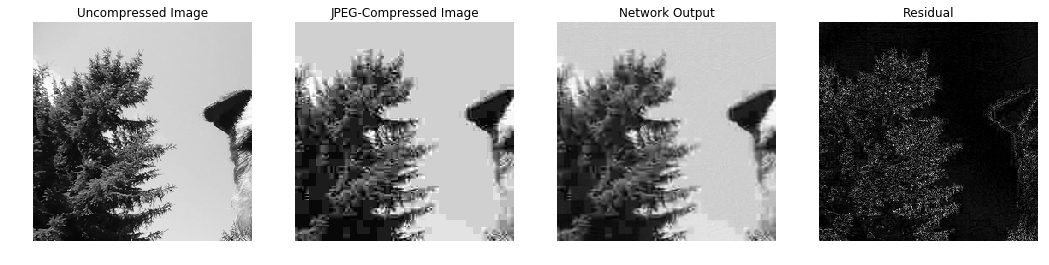

In [7]:
#print(pred)

slc = 65

print(np.min(test_unc[slc,:,:,0]), np.max(test_unc[slc,:,:,0]))
print(np.min(pred[slc,:,:,0]),np.max(pred[slc,:,:,0]))

# plt.figure(figsize = (9,18))
# plt.subplot(3,1,1)
# plt.axis("off")
# plt.title("Uncompressed Image", fontsize=24)
# plt.imshow(dct_test_unc[slc,:,:,0],cmap = "gray")
# plt.subplot(3,1,2)
# plt.axis("off")
# plt.title("Network Output", fontsize=24)
# plt.imshow(pred[slc,:,:,0],cmap = "gray")
# plt.subplot(3,1,3)
# plt.axis("off")
# plt.title("Residual", fontsize=24)
# plt.imshow((dct_test_unc[slc,:,:,0] - img_pred[slc,:,:,0]),cmap = "gray")
# plt.show()

plt.figure(figsize = (18,12))
plt.subplot(1,4,1)
plt.axis("off")
plt.title("Uncompressed Image")
plt.imshow(test_unc[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,2)
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.imshow(test_compr[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,3)
plt.axis("off")
plt.title("Network Output")
plt.imshow(pred[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,4)
plt.axis("off")
plt.title("Residual")
plt.imshow(abs(test_unc[slc,:,:,0] - pred[slc,:,:,0]),cmap = "gray")
plt.show()

Test set results
0.0 254.0
-7.5488586 251.3346
0.0 228.0
-1.7221832 240.19873
0.0 255.0
-6.709656 260.1735


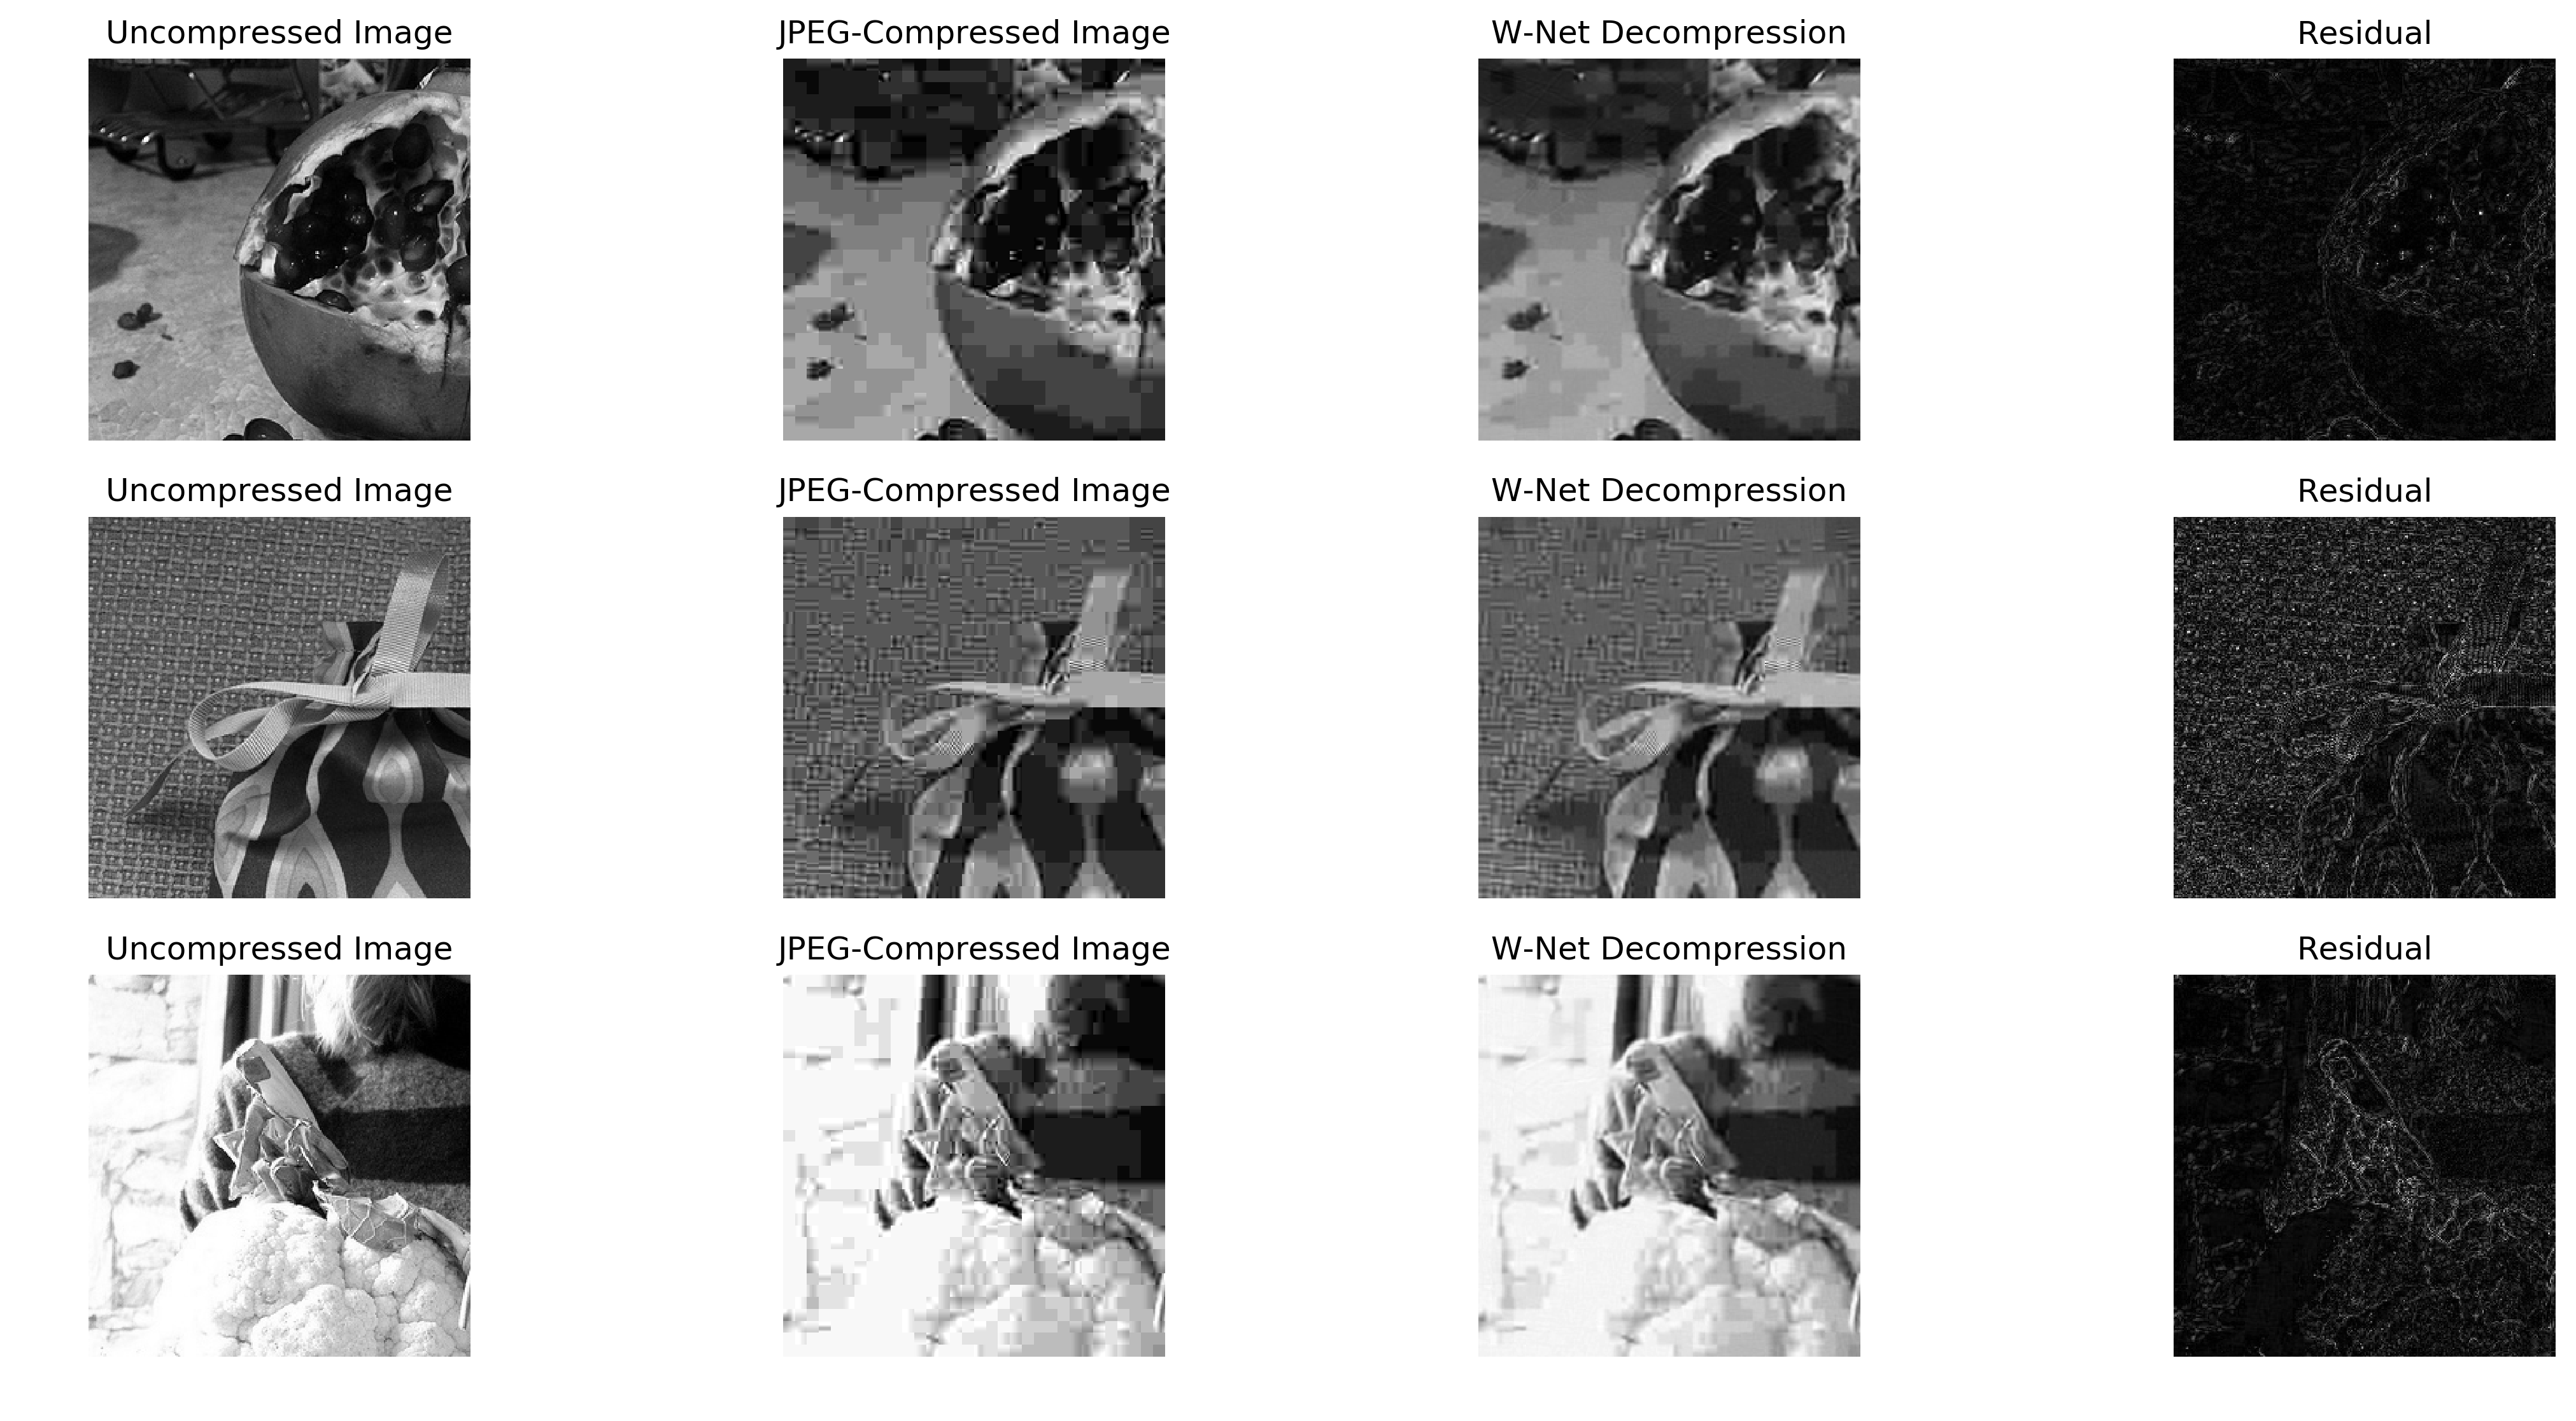

In [8]:
indexes_test = np.arange(len(pred),dtype = int)
np.random.shuffle(indexes_test)
indexes_test = indexes_test[:3]

print("Test set results")
plt.figure(figsize = (18,9),dpi = 300)
for ii in range(3):
    print(np.min(test_unc[indexes_test[ii],:,:,0]),np.max(test_unc[indexes_test[ii],:,:,0]))
    print(np.min(pred[indexes_test[ii],:,:,0]),np.max(pred[indexes_test[ii],:,:,0]))

    plt.subplot(3,4,4*ii+1)
    plt.imshow(test_unc[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed Image")
    plt.subplot(3,4,4*ii+2)
    plt.imshow(test_compr[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("JPEG-Compressed Image")
    plt.subplot(3,4,4*ii+3)
    plt.imshow(pred[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("W-Net Decompression")
    plt.subplot(3,4,4*ii+4)
    plt.imshow(abs(test_unc[indexes_test[ii],:,:,0] - pred[indexes_test[ii],:,:,0]),cmap = "gray")
    plt.axis("off")
    plt.title("Residual")
plt.show()     

# Performance Metrics

In [9]:
metr = np.zeros((len(pred),3,2),dtype=np.float32)
print(metr.shape)

count = 0
for ii in range(len(pred)): 
    
    # Check if the metric values are finite
    # JPEG-Compressed Metrics
    a = metrics.compare_ssim(test_unc[ii,:,:,0],test_compr[ii,:,:,0])
    if ~np.isfinite(a):
        print("removing %i SSIM from JPEG list." %ii)
        count += 1
        continue
        
    b = metrics.compare_psnr(test_unc[ii,:,:,0],test_compr[ii,:,:,0],\
                                        data_range=(test_compr[ii,:,:,0].max()-test_compr[ii,:,:,0].min()))
    if ~np.isfinite(b):
        print("removing %i PSNR from JPEG list." %ii)
        count += 1
        continue
        
    c = metrics.compare_nrmse(test_unc[ii,:,:,0],test_compr[ii,:,:,0],'min-max') *100.0
    if ~np.isfinite(c):
        print("removing %i NRMSE from JPEG list." %ii)
        count += 1
        continue

    # Network metrics
    d = metrics.compare_ssim(test_unc[ii,:,:,0],pred[ii,:,:,0])
    if ~np.isfinite(d):
        print("removing %i SSIM from network list." %ii)
        count += 1
        continue
        
    e = metrics.compare_psnr(test_unc[ii,:,:,0],pred[ii,:,:,0],\
                                       data_range=(pred[ii,:,:,0].max()-pred[ii,:,:,0].min()))
    if ~np.isfinite(e):
        print("removing %i PSNR from network list." %ii)
        count += 1
        continue
        
    f = metrics.compare_nrmse(test_unc[ii,:,:,0],pred[ii,:,:,0],'min-max') *100.0
    if ~np.isfinite(f):
        print("removing %i NRMSE from network list." %ii)
        count += 1
        continue
    
    metr[ii,0,0] = a
    metr[ii,1,0] = b
    metr[ii,2,0] = c
    metr[ii,0,1] = d
    metr[ii,1,1] = e    
    metr[ii,2,1] = f
    
# remove empty rows
metr = np.delete(metr,range(len(metr)-count, len(metr)),axis=0)
print(metr.shape)
    
#     # JPEG-Compressed Metrics
#     metr[ii,0,0] = metrics.compare_ssim(test_unc[ii,:,:,0],test_compr[ii,:,:,0])
#     metr[ii,1,0] = metrics.compare_psnr(test_unc[ii,:,:,0],test_compr[ii,:,:,0],\
#                                         data_range=(test_compr[ii,:,:,0].max()-test_compr[ii,:,:,0].min()))
#     metr[ii,2,0] = metrics.compare_nrmse(test_unc[ii,:,:,0],test_compr[ii,:,:,0],'min-max') *100.0
    
#     # Network Metrics
#     metr[ii,0,1] = metrics.compare_ssim(test_unc[ii,:,:,0],pred[ii,:,:,0])
#     metr[ii,1,1] = metrics.compare_psnr(test_unc[ii,:,:,0],pred[ii,:,:,0],\
#                                        data_range=(pred[ii,:,:,0].max()-pred[ii,:,:,0].min()))
#     metr[ii,2,1] = metrics.compare_nrmse(test_unc[ii,:,:,0],pred[ii,:,:,0],'min-max') *100.0
    
print("\nJPEG-Compressed Metrics")
print("SSIM: %.3f +/- %.3f" %(metr[:,0,0].mean(),metr[:,0,0].std()))
print("PSNR: %.3f +/- %.3f" %(metr[:,1,0].mean(),metr[:,1,0].std()))
print("NRMSE: %.3f +/- %.3f" %(metr[:,2,0].mean(),metr[:,2,0].std()))
print('\n')
print("Network Metrics")
print("SSIM: %.3f +/- %.3f" %(metr[:,0,1].mean(),metr[:,0,1].std()))
print("PSNR: %.3f +/- %.3f" %(metr[:,1,1].mean(),metr[:,1,1].std()))
print("NRMSE: %.3f +/- %.3f" %(metr[:,2,1].mean(),metr[:,2,1].std()))

(3624, 3, 2)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:142: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10((data_range ** 2) / err)


removing 970 PSNR from JPEG list.
removing 1025 PSNR from JPEG list.
removing 1601 PSNR from JPEG list.
(3621, 3, 2)

JPEG-Compressed Metrics
SSIM: 0.355 +/- 0.149
PSNR: 24.664 +/- 2.925
NRMSE: 6.239 +/- 2.207


Network Metrics
SSIM: 0.362 +/- 0.142
PSNR: 25.365 +/- 2.869
NRMSE: 5.805 +/- 2.157


In [10]:
for ii in range(0,1) # error on purpose to stop 'run all' here
    print(ii)

SyntaxError: invalid syntax (<ipython-input-10-cc9a80005530>, line 1)

In [ ]:
for ii in range(len(metr)):
    print(ii, metr[ii,1,0], metr[ii,1,1])
    if not np.isfinite(metr[ii,1,0]):
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    elif not np.isfinite(metr[ii,1,1]):
        print("###################################################")
#print(np.min(test_unc), np.max(test_unc))
#print(np.min(test_compr), np.max(test_compr))
#print(np.min(img_pred), np.max(pred))

In [ ]:
#print(pred)

slc = 1601

print(np.min(test_unc[slc,:,:,0]), np.max(test_unc[slc,:,:,0]))
print(np.min(pred[slc,:,:,0]),np.max(pred[slc,:,:,0]))

# plt.figure(figsize = (9,18))
# plt.subplot(3,1,1)
# plt.axis("off")
# plt.title("Uncompressed Image", fontsize=24)
# plt.imshow(dct_test_unc[slc,:,:,0],cmap = "gray")
# plt.subplot(3,1,2)
# plt.axis("off")
# plt.title("Network Output", fontsize=24)
# plt.imshow(pred[slc,:,:,0],cmap = "gray")
# plt.subplot(3,1,3)
# plt.axis("off")
# plt.title("Residual", fontsize=24)
# plt.imshow((dct_test_unc[slc,:,:,0] - img_pred[slc,:,:,0]),cmap = "gray")
# plt.show()

plt.figure(figsize = (18,12))
plt.subplot(1,4,1)
plt.axis("off")
plt.title("Uncompressed Image")
plt.imshow(test_unc[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,2)
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.imshow(test_compr[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,3)
plt.axis("off")
plt.title("Network Output")
plt.imshow(pred[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,4)
plt.axis("off")
plt.title("Residual")
plt.imshow(abs(test_unc[slc,:,:,0] - pred[slc,:,:,0]),cmap = "gray")
plt.show()

In [ ]:
for ii in range(len(pred)):
    test1 = metrics.compare_psnr(test_unc[ii,:,:,0],test_compr[ii,:,:,0],\
                                       data_range=(test_compr[ii,:,:,0].max()-test_compr[ii,:,:,0].min()))
    test2 = metrics.compare_psnr(test_unc[ii,:,:,0],img_pred[ii,:,:,0],\
                                       data_range=(img_pred[ii,:,:,0].max()-img_pred[ii,:,:,0].min()))
    print(ii, test1,test2)


In [ ]:
ii = 3615
print(np.min(test_unc[ii,:,:,0]),np.max(test_unc[ii,:,:,0]))
print(np.min(pred[ii,:,:,0]),np.max(pred[ii,:,:,0]))

plt.figure(figsize=(18,9))
plt.subplot(3,4,1)
plt.imshow(test_unc[ii,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("Uncompressed Image")
plt.subplot(3,4,2)
plt.imshow(test_compr[ii,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.subplot(3,4,3)
plt.imshow(pred[ii,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("U-Net Decompression")
plt.subplot(3,4,4)
plt.imshow(test_unc[ii,:,:,0] - pred[ii,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("Residual")
plt.show()    

In [ ]:
metr[~np.isfinite(metr).any(axis=2)]
print(metr.shape)

In [ ]:
print(range(len(metr)-count, len(metr)))
print(metr.shape)

In [ ]:
print("JPEG-Compressed Metrics")
print("SSIM: %.3f +/- %.3f" %(metr[:,0,0].mean(),metr[:,0,0].std()))
print("PSNR: %.3f +/- %.3f" %(metr[:,1,0].mean(),metr[:,1,0].std()))
print("NRMSE: %.3f +/- %.3f" %(metr[:,2,0].mean(),metr[:,2,0].std()))
print('\n')
print("Network Metrics")
print("SSIM: %.3f +/- %.3f" %(metr[:,0,1].mean(),metr[:,0,1].std()))
print("PSNR: %.3f +/- %.3f" %(metr[:,1,1].mean(),metr[:,1,1].std()))
print("NRMSE: %.3f +/- %.3f" %(metr[:,2,1].mean(),metr[:,2,1].std()))

In [ ]:
def dct2d(im):
    return DCT(DCT(im,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')
def idct2d(mat):
    return IDCT(IDCT(mat,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')

def dct_in_blocks(im, block_size = 8):

    rows, cols = im.shape[0], im.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    dct_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = im[i:i+block_size, j:j+block_size]
            dct_matrix[i:i+block_size,j:j+block_size] = dct2d(block)

    return dct_matrix

def idct_in_blocks(dct_mat, block_size = 8):

    rows, cols = dct_mat.shape[0], dct_mat.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    im_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = dct_mat[i:i+block_size, j:j+block_size]
            im_matrix[i:i+block_size,j:j+block_size] = idct2d(block)

    return im_matrix
